## Questions

I assume the affiliation should be for the year when the author published/the editor was an editor? Is that available in MAG?

Difference between `OriginalAffiliation` (in PaperAuthorAffiliations) and `LastKnownAffiliationId` (in Authors)? How would I get `OriginalAffiliation` for editors?

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as so
so.set_theme()
so.set_palette("mako")
custom_palette = ["#1e121f", "#3a2d5b", "#3e5095", "#357aa3", "#36a3ab", "#58cbad", "#b9e6c7"]
so.set_palette(custom_palette)
# so.set_theme(style='white')

In [2]:
"""
affiliation bins
"""
AFF_LABELS = ['1-10', '11-50', '51-100', '101-200', '201-500', '501-1000', '1000+']

In [3]:
def rebin(row):
    if row['rank'].isdigit() and 1 <= int(row['rank']) <= 10:
        val = '1-10'
    elif row['rank'].isdigit() and  11 <= int(row['rank']) <= 50:
        val = '11-50'
    elif row['rank'].isdigit() and  51 <= int(row['rank']) <= 100:
        val = '51-100'
    elif (row['rank'] == '101-150')|(row['rank'] == '151-200'):
        val = '101-200'
    elif (row['rank'] == '201-300')|(row['rank'] == '301-400')|(row['rank'] == '401-500'):
        val = '201-500'
    elif (row['rank'] == '501-600')|(row['rank'] == '601-700')|(row['rank'] == '701-800')|(row['rank'] == '801-900')|(row['rank'] == '901-1000'):
        val = '501-1000'
    elif row['rank'] == '1000+':
        val = '1000+'
    else:
        val = 'other'
    return val

In [4]:
def bucketize_affiliations(author_data, editor_data, tenures, affiliation_rank, bins, labels):
    authors = pd.read_csv(author_data).drop(labels=['Unnamed: 0'], axis=1)
    editors = pd.read_csv(editor_data).drop(labels=['Unnamed: 0'], axis=1)
    tenures = pd.read_csv(tenures, usecols=['Name', 'Role', 'End'], 
                          names=['Name', 'Role', 'Start', 'End', 'Affiliation'])
    ranks = pd.read_csv(affiliation_rank).drop(labels=['Unnamed: 0'], axis=1)
    
    editors = editors.merge(tenures, on=['Name'], how='inner')
    editors = editors.astype({'End': 'int64'})
    
    authors = authors.dropna(subset=['LastKnownAffiliationId'])
    editors = editors.dropna(subset=['LastKnownAffiliationId'])
    
    author_bins = authors.join(ranks.set_index('AffID'), on='LastKnownAffiliationId', how='left', rsuffix='_bin')
    editor_bins = editors.join(ranks.set_index('AffID'), on='LastKnownAffiliationId', how='left', rsuffix='_bin')
    
    author_bins['Bucket'] = pd.cut(x = author_bins['Year'], bins = bins, labels = labels, include_lowest = True)
    editor_bins['Bucket'] = pd.cut(x = editor_bins['End'], bins = bins, labels = labels, include_lowest = True)
    
    author_bins = author_bins.fillna(value={"rank":"1000+"})
    editor_bins = editor_bins.fillna(value={"rank":"1000+"})
    author_bins['newBins'] = author_bins.apply(rebin, axis=1)
    editor_bins['newBins'] = editor_bins.apply(rebin, axis=1)
    
    author_aff = author_bins.groupby(['Bucket'])
    editor_aff = editor_bins.groupby(['Bucket'])
    
    author_counts = author_aff['newBins'].value_counts(normalize=False).to_frame().reset_index(level=[0,1])
    editor_counts = editor_aff['newBins'].value_counts(normalize=False).to_frame().reset_index(level=[0,1])
    author_counts['newBins'] = pd.Categorical(author_counts['newBins'], AFF_LABELS, ordered=True)
    editor_counts['newBins'] = pd.Categorical(editor_counts['newBins'], AFF_LABELS, ordered=True)
    
    author_res = author_aff['newBins'].value_counts(normalize=True).to_frame().reset_index(level=[0,1])
    editor_res = editor_aff['newBins'].value_counts(normalize=True).to_frame().reset_index(level=[0,1])
    author_res['newBins'] = pd.Categorical(author_res['newBins'], AFF_LABELS, ordered=True)
    editor_res['newBins'] = pd.Categorical(editor_res['newBins'], AFF_LABELS, ordered=True)
    
    author_counts = author_counts.sort_values(by=['Bucket', 'newBins'])
    editor_counts = editor_counts.sort_values(by=['Bucket', 'newBins'])
    author_res = author_res.sort_values(by=['Bucket', 'newBins'])
    editor_res = editor_res.sort_values(by=['Bucket', 'newBins'])
    
    return author_res, editor_res, author_counts, editor_counts

In [5]:
def call_bucketize_affiliations(journal):
    author_data = f"../author_data/cleaned/{journal}_authors_cleaned.csv"
    editor_data = f"./../mag_processed/random_duplicates/{journal}_random_duplicates.csv"
    tenures = f"./../editor_data/analysis/tenures/{journal}_tenures.csv"
    affiliations = f"./../normaffil_topuniversities_ranking_2019.csv"
    
    std_bins = [1994, 1998, 2003, 2008, 2013, 2018, 2023]
    std_labels = ['1994-1998', '1999-2003', '2004-2008', '2009-2013', '2014-2018', '2018-2023']
    
    eco_bins = [2007, 2011, 2016, 2021, 2023]
    eco_labels = ['2007-2011', '2012-2016', '2017-2021', '2022-2023']

#     jpe_bins = [2017, 2020, 2023]
#     jpe_labels = ['2017-2019', '2020-2023']
    jpe_bins = [2016, 2017, 2018, 2019, 2020, 2021, 2022,2023]
    jpe_labels = ['2017', '2018', '2019', '2020', '2021', '2022','2023']

    if journal == "agg":
        a, e, ac, ec = bucketize_affiliations(f"../author_data/cleaned/aggregate_authors_cleaned.csv", 
                                      f"./../mag_processed/random_duplicates/aggregate_random_duplicates.csv",
                                      f"./../editor_data/analysis/tenures/aggregate_tenures.csv", 
                                      affiliations, std_bins, std_labels)
        return a, e, ac, ec, std_labels
    elif journal == "eco":
        a, e, ac, ec = bucketize_affiliations(author_data, editor_data, tenures, affiliations, eco_bins, eco_labels)
        return a, e, ac, ec, eco_labels
    elif journal == "jpe":
        a, e, ac, ec = bucketize_affiliations(author_data, editor_data, tenures, affiliations, jpe_bins, jpe_labels)
        return a, e, ac, ec, jpe_labels
    else:
        a, e, ac, ec = bucketize_affiliations(author_data, editor_data, tenures, affiliations, std_bins, std_labels)
        return a, e, ac, ec, std_labels

In [6]:
aer_authors, aer_editors, aer_author_counts, aer_editor_counts, aer_labels = call_bucketize_affiliations("aer")
eco_authors, eco_editors, eco_author_counts, eco_editor_counts, eco_labels = call_bucketize_affiliations("eco")
jpe_authors, jpe_editors, jpe_author_counts, jpe_editor_counts, jpe_labels = call_bucketize_affiliations("jpe")
qje_authors, qje_editors, qje_author_counts, qje_editor_counts, qje_labels = call_bucketize_affiliations("qje")
res_authors, res_editors, res_author_counts, res_editor_counts, res_labels = call_bucketize_affiliations("res")

In [7]:
agg_authors, agg_editors, agg_author_counts, agg_editor_counts, agg_labels = call_bucketize_affiliations("agg")

In [13]:
def plot_affiliations_line(author, editor, author_counts, editor_counts, journal, year_labels):
    top_200_authors = author_counts[(author_counts['newBins'] == '1-10') | 
                                    (author_counts['newBins'] == '11-50')|
                                    (author_counts['newBins'] == '51-100') |
                                    (author_counts['newBins'] == '101-200')]
    total_authors = [1-(top_200_authors['count'].sum()/author_counts['count'].sum()) for _ in range(len(year_labels))]
    top_200_editors = editor_counts[(editor_counts['newBins'] == '1-10') | 
                                    (editor_counts['newBins'] == '11-50')|
                                    (editor_counts['newBins'] == '51-100')|
                                    (editor_counts['newBins'] == '101-200')]
    total_editors = [1-(top_200_editors['count'].sum()/editor_counts['count'].sum()) for _ in range(len(year_labels))]
    
    author_data = []
    editor_data = []
    for label in AFF_LABELS:
        tmp_author = author[author['newBins'] == label].reset_index(drop=True)['proportion'].to_numpy()
        tmp_editor = editor[editor['newBins'] == label].reset_index(drop=True)['proportion'].to_numpy()
        if len(tmp_author) == 0:
            tmp_author = [0 for _ in range(len(year_labels))]
        if len(tmp_editor) == 0:
            tmp_editor = [0 for _ in range(len(year_labels))]
        author_data.append(tmp_author)
        editor_data.append(tmp_editor)
        
    author_plot = author_data[0]
    editor_plot = editor_data[0]
    for bin in author_data[1:4]:
        for i in range(len(author_plot)):
            author_plot[i] += bin[i]
    for bin in editor_data[1:4]:
        for j in range(len(editor_plot)):
            editor_plot[j] += bin[j] 
    author_plot_final = [1-x for x in author_plot]
    editor_plot_final = [1-x for x in editor_plot]
            
    axes = plt.axes()
    axes.set_ylim([0, 1])
    plt.rcParams["figure.figsize"] = [6.5, 6]
    plt.rcParams["figure.autolayout"] = True
    plt.plot(year_labels, total_authors, label='Overall Authors', color="#f34d4d", linestyle='dashed', alpha=0.5, lw=2)
    plt.plot(year_labels, total_editors, label='Overall Editors', color="#69bade", linestyle='dashed', alpha=0.5, lw=2)
    plt.plot(year_labels, author_plot_final, label='Authors', color="#f34d4d", lw=2.5)
    plt.plot(year_labels, editor_plot_final, label='Editors', color="#69bade", lw=2.5)
    plt.title(f'Percentage of Contributors Not Affiliated with Top 200 Institutions\n Across the "Top Five"', y=1.05)
    plt.xticks(year_labels, rotation=15)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.spines[['right', 'top']].set_visible(False)
    plt.legend()
#     plt.savefig(f'../graphs/aggregate_affiliation.png')
    plt.show()

In [38]:
def plot_affiliations_stack(author, editor, journal, year_labels):
    author_data = []
    editor_data = []
    for label in AFF_LABELS:
        tmp_author = author[author['newBins'] == label].reset_index(drop=True)['proportion'].to_numpy()
        tmp_editor = editor[editor['newBins'] == label].reset_index(drop=True)['proportion'].to_numpy()
        if len(tmp_author) == 0:
            tmp_author = [0 for _ in range(len(year_labels))]
        if len(tmp_editor) == 0:
            tmp_editor = [0 for _ in range(len(year_labels))]
        author_data.append(tmp_author)
        editor_data.append(tmp_editor)

    author_plot = np.vstack(author_data)
    editor_plot = np.vstack(editor_data)
    
    plt.stackplot(year_labels, author_plot, labels=AFF_LABELS)
    plt.title(f'Affiliation Rankings of Authors at {journal.upper()}')
#     plt.legend(bbox_to_anchor=(1,0.5) , loc='lower left')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
#     plt.savefig(f'../graphs/{journal}_author_affiliation.png')
    plt.show()
    
    plt.stackplot(year_labels, editor_plot, labels=AFF_LABELS)
    plt.title(f'Affiliation Rankings of Editors at {journal.upper()}')
#     plt.legend(bbox_to_anchor=(1,0.5) , loc='lower left')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
#     plt.savefig(f'../graphs/{journa}_editor_affiliation.png')
    plt.show()


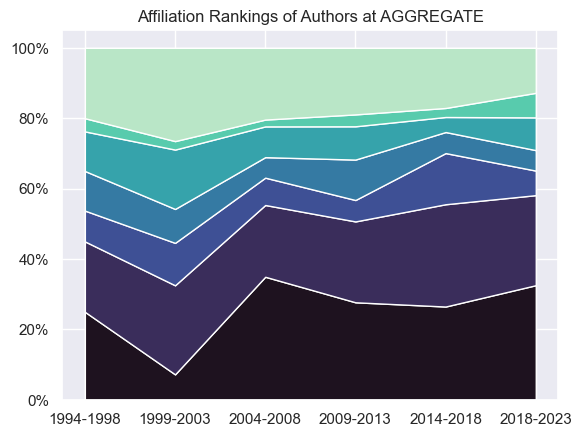

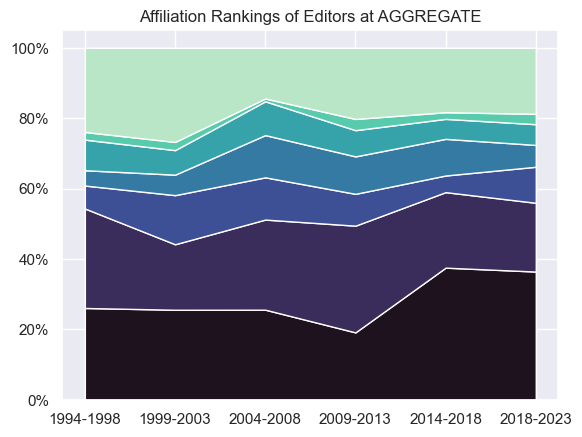

In [39]:
plot_affiliations_stack(agg_authors, agg_editors, "aggregate", agg_labels)

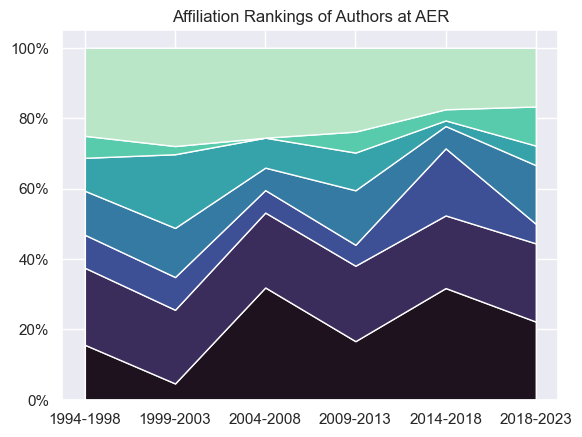

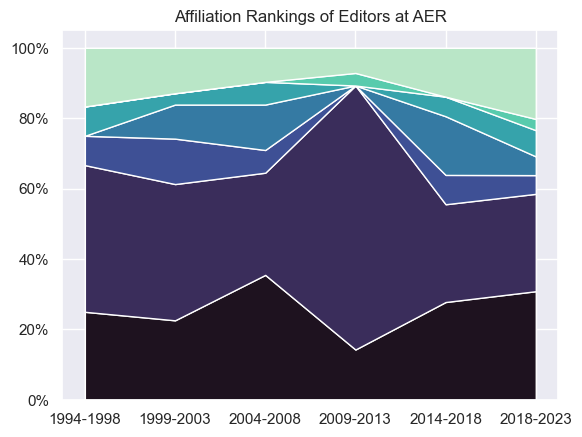

In [40]:
plot_affiliations_stack(aer_authors, aer_editors, "aer", aer_labels)

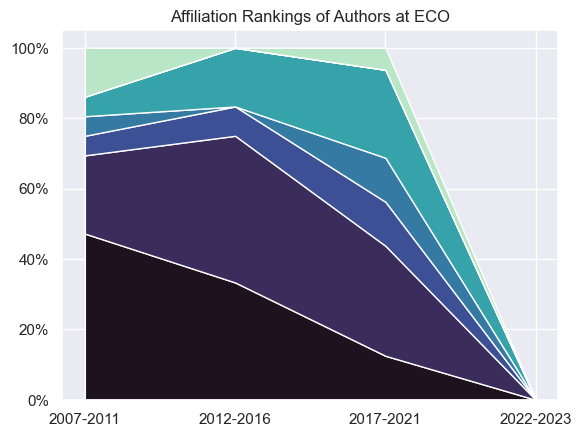

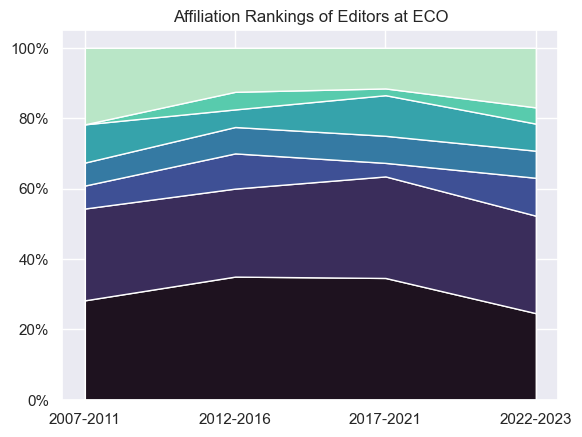

In [41]:
plot_affiliations_stack(eco_authors, eco_editors, "eco", eco_labels)

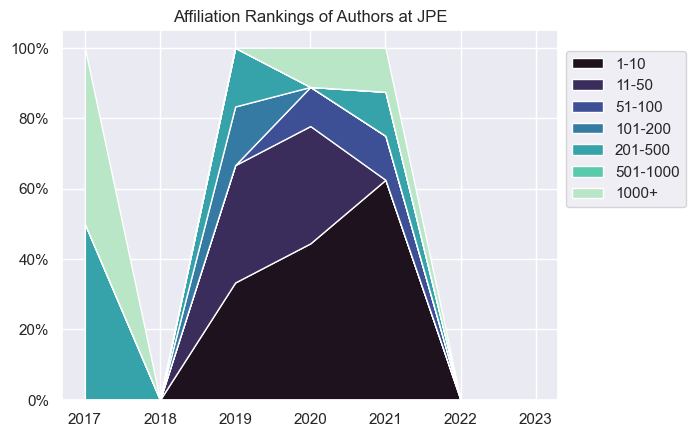

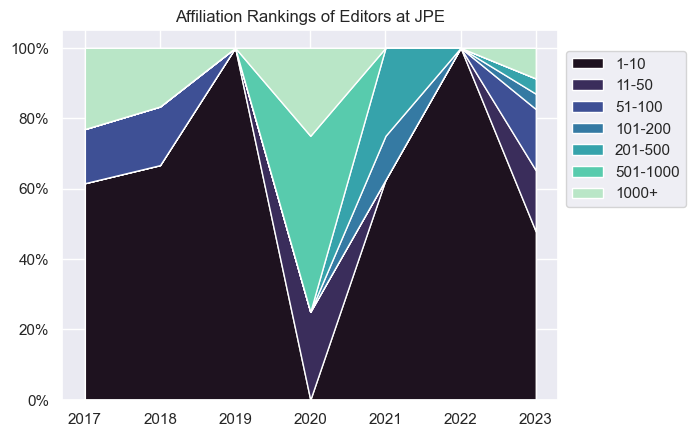

In [28]:
plot_affiliations_stack(jpe_authors, jpe_editors, "jpe", jpe_labels)

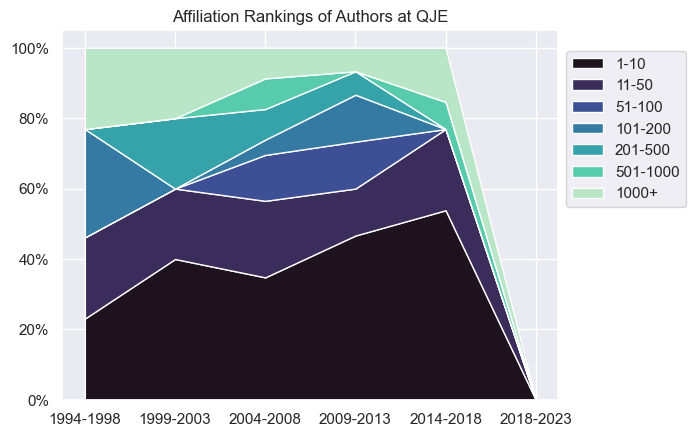

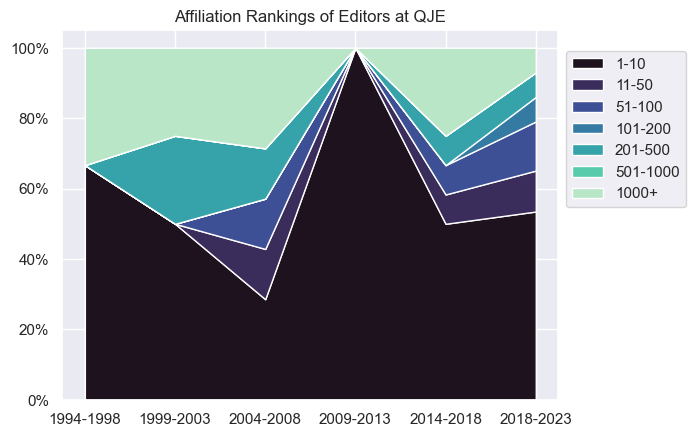

In [29]:
plot_affiliations_stack(qje_authors, qje_editors, "qje", qje_labels)

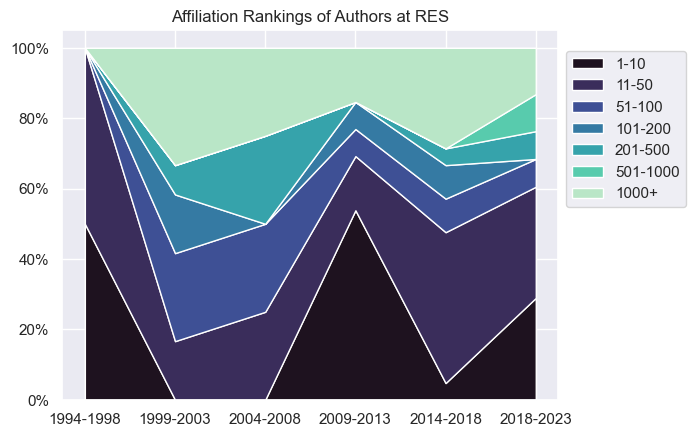

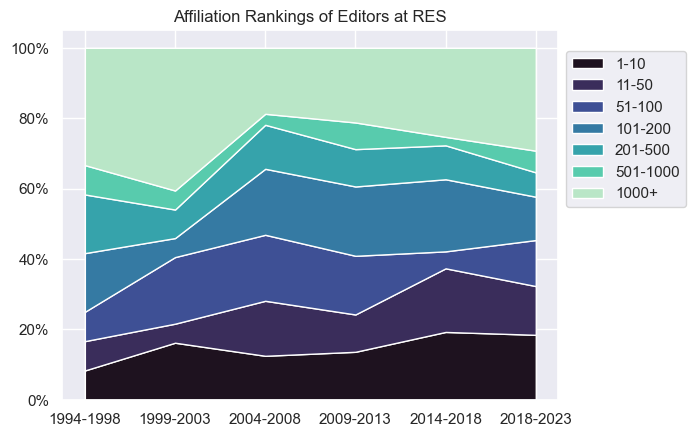

In [30]:
plot_affiliations_stack(res_authors, res_editors, "res", res_labels)